In [3]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
movies = pd.read_csv("../data/movies.csv", low_memory=False)
names = pd.read_csv("../data/names.csv", low_memory=False)
ratings = pd.read_csv("../data/ratings.csv", low_memory=False)
title = pd.read_csv("../data/title_principals.csv", low_memory=False)

In [4]:
#Dropeos

#Movies, De budget en adelante todo tienen mas del 50% nulos
#Names, solo me quedo con id y name
#ratings, allgenders_0age_avg_vote, allgenders_0age_votes, males_0age_avg_vote, males_0age_votes, females_0age_avg_vote, females_0age_votes
#Title, me quedo con los id, ordering y category

In [5]:
movies_country = movies.groupby(by="country").agg({'imdb_title_id':'count'})
#Agrupamos por pais

In [6]:
movies_country.imdb_title_id.sort_values(ascending=False)
#Ordenamos para ver si podemos quedarnos solo con USA

country
USA                                              28511
India                                             6065
UK                                                4111
Japan                                             3077
France                                            3055
                                                 ...  
Poland, Switzerland, Germany, Denmark, France        1
Poland, Spain                                        1
Poland, South Africa                                 1
Poland, Slovakia, Czech Republic                     1
Italy, USA, Austria                                  1
Name: imdb_title_id, Length: 4907, dtype: int64

In [7]:
movies_usa = movies[movies['country']=='USA']
#Creamos el dataset para trabajar solo con USA

In [8]:
print("nulls: {0}".format(movies_usa.budget.isnull().sum()))
print("no nulls: {0}".format(movies_usa.budget.notnull().sum()))
#Vemos los nulls y no nulls para determinar si podemos completarlo con un modelo de regresion

nulls: 18023
no nulls: 10488


In [14]:
movies_usa[movies_usa['imdb_title_id']=="tt9898858"]

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
85839,tt9898858,Coffee & Kareem,Coffee & Kareem,2020,2020-04-03,"Action, Comedy",88,USA,English,Michael Dowse,...,"Ed Helms, Taraji P. Henson, Terrence Little Ga...",Twelve-year-old Kareem Manning hires a crimina...,5.1,10627,NaN,NaN,NaN,35.0,388.0,64.0


In [15]:
title[title['imdb_title_id']=="tt9898858"]

,imdb_title_id,ordering,imdb_name_id,category,job,characters
835360,tt9898858,1,nm1159180,actor,NaN,"[""Coffee""]"
835361,tt9898858,2,nm0378245,actress,NaN,"[""Vanessa Manning""]"
835362,tt9898858,3,nm10067359,actor,NaN,"[""Kareem""]"
835363,tt9898858,4,nm2365811,actress,NaN,"[""Detective Watts""]"
835364,tt9898858,5,nm0236226,director,NaN,NaN
835365,tt9898858,6,nm3377973,writer,NaN,NaN
835366,tt9898858,7,nm3824648,producer,producer,NaN
835367,tt9898858,8,nm2468967,composer,NaN,NaN
835368,tt9898858,9,nm1125431,cinematographer,NaN,NaN
835369,tt9898858,10,nm0299982,editor,NaN,NaN


In [16]:
title_act = title[title['category'].isin(['actor', 'actress'])].copy()
#separo para quedarme solo on los actores

In [17]:
title_act

,imdb_title_id,ordering,imdb_name_id,category,job,characters
0,tt0000009,1,nm0063086,actress,NaN,"[""Miss Geraldine Holbrook (Miss Jerry)""]"
1,tt0000009,2,nm0183823,actor,NaN,"[""Mr. Hamilton""]"
2,tt0000009,3,nm1309758,actor,NaN,"[""Chauncey Depew - the Director of the New Yor..."
4,tt0000574,1,nm0846887,actress,NaN,"[""Kate Kelly""]"
5,tt0000574,2,nm0846894,actor,NaN,"[""School Master""]"
...,...,...,...,...,...,...
835497,tt9914286,4,nm10569025,actor,NaN,NaN
835503,tt9914942,1,nm10814833,actress,NaN,"[""Sara Amat""]"
835504,tt9914942,2,nm10823679,actor,NaN,"[""Pep""]"
835505,tt9914942,3,nm1290838,actor,NaN,NaN


In [18]:
title_clean = title_act.groupby('imdb_title_id').head(3).reset_index(drop=True)
#nos quedamos con los primeros 3 actores para cada pelicula
actores = title_clean[["imdb_title_id","imdb_name_id"]]
actores

,imdb_title_id,imdb_name_id
0,tt0000009,nm0063086
1,tt0000009,nm0183823
2,tt0000009,nm1309758
3,tt0000574,nm0846887
4,tt0000574,nm0846894
...,...,...
256336,tt9914286,nm7659571
256337,tt9914286,nm2456249
256338,tt9914942,nm10814833
256339,tt9914942,nm10823679


In [19]:
movies_usa.drop(columns=["actors", "budget", "language", "writer", "original_title", "date_published", "country", "usa_gross_income", "worlwide_gross_income"], inplace=True)

C:\Users\gonza\anaconda3\envs\dhdsblend\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
movies_usa_set = movies_usa.merge(actores, on="imdb_title_id")
#mergeamos el los actores id 

In [21]:
movies_usa_set.head()

,imdb_title_id,title,year,genre,duration,director,production_company,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,imdb_name_id
0,tt0000009,Miss Jerry,1894,Romance,45,Alexander Black,Alexander Black Photoplays,The adventures of a female reporter in the 1890s.,5.9,154,NaN,1.0,2.0,nm0063086
1,tt0000009,Miss Jerry,1894,Romance,45,Alexander Black,Alexander Black Photoplays,The adventures of a female reporter in the 1890s.,5.9,154,NaN,1.0,2.0,nm0183823
2,tt0000009,Miss Jerry,1894,Romance,45,Alexander Black,Alexander Black Photoplays,The adventures of a female reporter in the 1890s.,5.9,154,NaN,1.0,2.0,nm1309758
3,tt0002101,Cleopatra,1912,"Drama, History",100,Charles L. Gaskill,Helen Gardner Picture Players,The fabled queen of Egypt's affair with Roman ...,5.2,446,NaN,25.0,3.0,nm0306947
4,tt0002101,Cleopatra,1912,"Drama, History",100,Charles L. Gaskill,Helen Gardner Picture Players,The fabled queen of Egypt's affair with Roman ...,5.2,446,NaN,25.0,3.0,nm0801774


In [22]:
asd = movies_usa_set[movies_usa_set.metascore.notnull()]

In [23]:
asd.groupby(by="year").count().tail(10)

,imdb_title_id,title,genre,duration,director,production_company,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,imdb_name_id
year,,,,,,,,,,,,,
2012,726,726,726,726,726,708,723,726,726,726,720,726,726
2013,853,853,853,853,853,829,853,853,853,853,850,850,853
2014,917,917,917,917,917,887,917,917,917,917,917,917,917
2015,732,732,732,732,732,717,732,732,732,732,726,729,732
2016,709,709,709,709,709,682,709,709,709,709,709,709,709
2017,775,775,775,775,775,762,775,775,775,775,775,775,775
2018,806,806,806,806,806,779,803,806,806,806,803,803,806
2019,684,684,684,684,684,675,681,684,684,684,678,684,684
2020,299,299,299,299,299,296,296,299,299,299,293,299,299


In [24]:
asd2 = asd[asd["year"]!="TV Movie 2019"]

In [25]:
asd2.year = asd2.year.astype("int")

C:\Users\gonza\anaconda3\envs\dhdsblend\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:ylabel='year'>

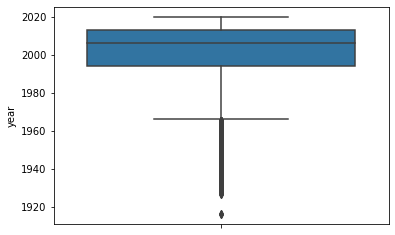

In [26]:
sns.boxplot(y=asd2["year"])

In [27]:
asd2.year.describe()

count    19788.000000
mean      2001.239438
std         16.445987
min       1916.000000
25%       1994.000000
50%       2006.000000
75%       2013.000000
max       2020.000000
Name: year, dtype: float64

In [28]:
Q1 = asd2["year"].quantile(0.25)
Q3 = asd2["year"].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (asd2["year"] >= Q1 - 1.5 * IQR) & (asd2["year"] <= Q3 + 1.5 *IQR)
df = asd2.loc[filter]
#Filtramos para sacar los outliers de year

In [29]:
#df.to_csv('movies2', sep="|", index=False)
#Creo el csv de movies ya limpio

In [50]:
df.isnull().sum()

imdb_title_id             0
title                     0
year                      0
genre                     0
duration                  0
director                  0
production_company      268
description              39
avg_vote                  0
votes                     0
metascore                 0
reviews_from_users       45
reviews_from_critics     15
imdb_name_id              0
dtype: int64

In [84]:
generos = df["genre"].str.split(pat=",").explode()

In [155]:
df2 = df.merge(generos, left_index=True, right_index=True)

In [156]:
df2.drop(columns=["genre_x"], inplace=True)

In [157]:
df2.rename(columns={"genre_y":"genre"},inplace=True)

In [158]:
df2.dropna(inplace=True)

In [159]:
df2

,imdb_title_id,title,year,duration,director,production_company,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,imdb_name_id,genre
10377,tt0035423,Kate & Leopold,2001,118,James Mangold,Konrad Pictures,An English Duke from 1876 is inadvertedly drag...,6.4,77852,44.0,341.0,115.0,nm0000212,Comedy
10377,tt0035423,Kate & Leopold,2001,118,James Mangold,Konrad Pictures,An English Duke from 1876 is inadvertedly drag...,6.4,77852,44.0,341.0,115.0,nm0000212,Fantasy
10377,tt0035423,Kate & Leopold,2001,118,James Mangold,Konrad Pictures,An English Duke from 1876 is inadvertedly drag...,6.4,77852,44.0,341.0,115.0,nm0000212,Romance
10378,tt0035423,Kate & Leopold,2001,118,James Mangold,Konrad Pictures,An English Duke from 1876 is inadvertedly drag...,6.4,77852,44.0,341.0,115.0,nm0413168,Comedy
10378,tt0035423,Kate & Leopold,2001,118,James Mangold,Konrad Pictures,An English Duke from 1876 is inadvertedly drag...,6.4,77852,44.0,341.0,115.0,nm0413168,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85023,tt9898858,Coffee & Kareem,2020,88,Michael Dowse,Pacific Electric Picture Company,Twelve-year-old Kareem Manning hires a crimina...,5.1,10627,35.0,388.0,64.0,nm1159180,Comedy
85024,tt9898858,Coffee & Kareem,2020,88,Michael Dowse,Pacific Electric Picture Company,Twelve-year-old Kareem Manning hires a crimina...,5.1,10627,35.0,388.0,64.0,nm0378245,Action
85024,tt9898858,Coffee & Kareem,2020,88,Michael Dowse,Pacific Electric Picture Company,Twelve-year-old Kareem Manning hires a crimina...,5.1,10627,35.0,388.0,64.0,nm0378245,Comedy
85025,tt9898858,Coffee & Kareem,2020,88,Michael Dowse,Pacific Electric Picture Company,Twelve-year-old Kareem Manning hires a crimina...,5.1,10627,35.0,388.0,64.0,nm10067359,Action


In [165]:
df2.drop(axis=1, index=[10377, 10378, 10379, 23747], inplace=True)

In [169]:
df2.isnull().sum()

imdb_title_id           0
title                   0
year                    0
duration                0
director                0
production_company      0
description             0
avg_vote                0
votes                   0
metascore               0
reviews_from_users      0
reviews_from_critics    0
imdb_name_id            0
genre                   0
dtype: int64

In [170]:
df2.to_csv("movies2", sep="|")